Train: (34254,)  Test: (336,)
Model Performance:
 {'ARIMA': {'MAE': 0.6753047409626279, 'RMSE': np.float64(0.8287247900849087)}, 'Prophet': {'MAE': nan, 'RMSE': nan}, 'XGBoost': {'MAE': 0.327845086976602, 'RMSE': np.float64(0.5219222302906497)}}


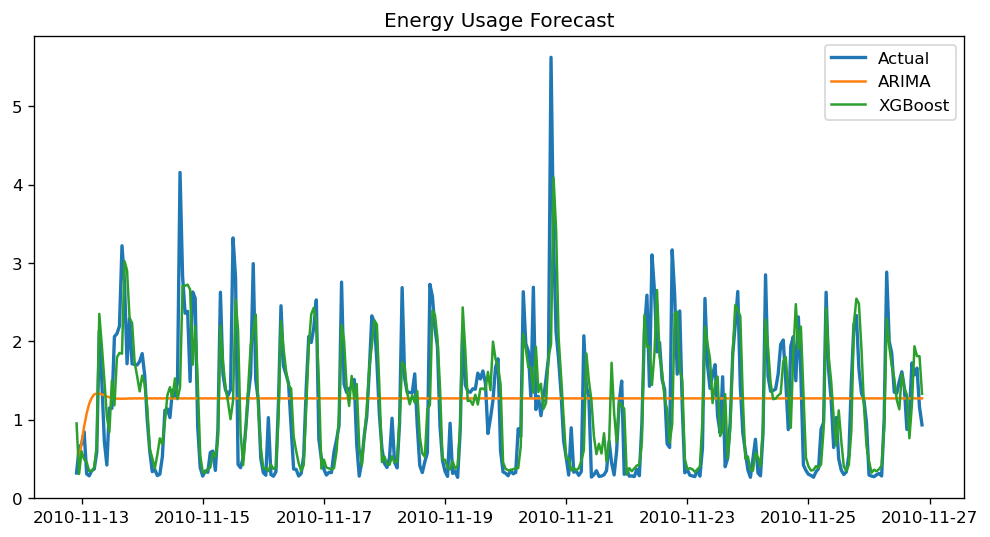

In [8]:
# ============================================================
# Task 3 – Energy Consumption Time Series Forecasting
# Models: ARIMA (statsmodels), Prophet (optional), XGBoost
# ============================================================

# ---------- 0) Setup
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# ARIMA from statsmodels
from statsmodels.tsa.arima.model import ARIMA

# Prophet (optional)
try:
    from prophet import Prophet
except:
    Prophet = None

plt.rcParams["figure.dpi"] = 120

# ---------- 1) Load Dataset
DATA_PATH = "household_power_consumption.txt"   # change if needed
TARGET_COL = "Global_active_power"
RESAMPLE_RULE = "H"
TEST_DAYS = 14

def load_power_data(path: str):
    df = pd.read_csv(
        path, sep=";", na_values=["?"], low_memory=False
    )
    df["DateTime"] = pd.to_datetime(
        df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S", errors="coerce"
    )
    df = df.drop(columns=["Date","Time"]).set_index("DateTime").sort_index()
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

df_raw = load_power_data(DATA_PATH)

# Resample hourly and enforce frequency
df_hourly = df_raw.resample(RESAMPLE_RULE).mean().dropna(subset=[TARGET_COL])
df_hourly = df_hourly.asfreq(RESAMPLE_RULE)

# ---------- 2) Train/Test Split
test_horizon = TEST_DAYS * 24
split_point = df_hourly.index[-test_horizon]
train_series = df_hourly.loc[:split_point][TARGET_COL]
test_series  = df_hourly.loc[split_point:][TARGET_COL]

print("Train:", train_series.shape, " Test:", test_series.shape)

# ---------- 3) ARIMA (statsmodels)
arima_model = ARIMA(train_series, order=(3,1,3))
arima_fit = arima_model.fit()
arima_fc = pd.Series(
    arima_fit.forecast(steps=len(test_series)),
    index=test_series.index
)

# ---------- 4) Prophet (if installed)
if Prophet is not None:
    df_prop = train_series.reset_index()
    df_prop.columns = ["ds","y"]
    m = Prophet(daily_seasonality=True, weekly_seasonality=True)
    m.fit(df_prop)
    future = pd.DataFrame({"ds": test_series.index})
    prophet_fc = m.predict(future).set_index("ds")["yhat"]
else:
    prophet_fc = pd.Series(index=test_series.index, dtype=float)

# ---------- 5) XGBoost
def add_time_features(frame):
    f = frame.copy()
    idx = f.index
    f["hour"] = idx.hour
    f["dayofweek"] = idx.dayofweek
    f["is_weekend"] = (idx.dayofweek>=5).astype(int)
    return f

df_feat = add_time_features(df_hourly[[TARGET_COL]])
for lag in [1,2,24,168]:
    df_feat[f"lag{lag}"] = df_feat[TARGET_COL].shift(lag)

df_feat = df_feat.dropna()
split_point = df_feat.index[-test_horizon]

train_feat = df_feat.loc[:split_point]
test_feat  = df_feat.loc[split_point:]

X_train = train_feat.drop(columns=[TARGET_COL])
y_train = train_feat[TARGET_COL]
X_test  = test_feat.drop(columns=[TARGET_COL])
y_test  = test_feat[TARGET_COL]

xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, n_jobs=-1)
xgb.fit(X_train, y_train)
xgb_fc = pd.Series(xgb.predict(X_test), index=y_test.index)

# ---------- 6) Metrics
def metrics(y, yhat):
    df = pd.concat([y, yhat], axis=1).dropna()
    return {
        "MAE": mean_absolute_error(df.iloc[:,0], df.iloc[:,1]),
        "RMSE": np.sqrt(mean_squared_error(df.iloc[:,0], df.iloc[:,1]))  # fixed
    }

results = {
    "ARIMA": metrics(test_series, arima_fc),
    "Prophet": metrics(test_series, prophet_fc) if prophet_fc.notna().any() else {"MAE":np.nan,"RMSE":np.nan},
    "XGBoost": metrics(y_test, xgb_fc)
}
print("Model Performance:\n", results)

# ---------- 7) Visualization
plt.figure(figsize=(10,5))
plt.plot(test_series.index, test_series, label="Actual", lw=2)
plt.plot(arima_fc.index, arima_fc, label="ARIMA")
if prophet_fc.notna().any():
    plt.plot(prophet_fc.index, prophet_fc, label="Prophet")
plt.plot(xgb_fc.index, xgb_fc, label="XGBoost")
plt.legend(); plt.title("Energy Usage Forecast")
plt.show()
